# H.E.R.M.E.S.

## Heuristic Enabled Rapid Modular Evolutionary Search

### File Housekeeping

In [1]:
import os
import os.path
import sys
d = os.path.join(os.getcwd(), '..')
print(d)
sys.path.append(d)

C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src\..


### Notebook Set-up

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure as Figure
from src.Other import Colours as CP
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# https://pandas.pydata.org/pandas-docs/stable/visualization.html
# http://pandas.pydata.org/pandas-docs/version/0.13/visualization.html
# https://matplotlib.org/users/pyplot_tutorial.html

# Set up the style of the graphs
graph_style = 5
plt.style.use(plt.style.available[graph_style])  # 5, 14, 22
plt.figure(figsize=(30, 15))
sns.set_context("paper")
None

### Imports

#### Set Imports

These imports do not need to change between runs.

The `EA_Shell` is module which contains the class `EARunner`. This is general shell that is designed to handle many problems. It can dynamically change wheteher it evaluates the optimum as a minimum or maximum, and can be given functions to use in the when running the evolutionary algorithm.

`Optimums` is a module which has information about known global optima or the best result obtained so far.

`TSP_Display` is a module which has the `GraphingHelper` class. It uses `pandas`, as well as some other modules in the project to parse the city locations, add them to a `DataFrame`, which can then easily be plotted. It can also be given an individual and plot the path that individual represents. It has two plottting methods, one which emphasises the city locations, and the other that emphasises the path.

In [3]:
from src.EA_Shell import EARunner as EA
from src.Setups.TSP.TSP_Inputs.Optimums import get_best_path
from src.Setups.TSP.TSP_Display import GraphingHelper as Grapher

#### Modular Imports

These imports can be changed to redefine the problem.

Here, the various modules which contain the methods for each step of the EA are imported. By switching the directory `.List_Rep` with another directory, the representation of the problem can easily be changed to use `numpy` or `C` arrays.

As well, the particualrs of the problem definition are imported here, and swapping out `TSP_LST` with the approriate module change the representation of the data.

In [4]:
from src.EA_Methods.List_Rep import ParentSelectionMethods as PSM
from src.EA_Methods.List_Rep import MutationMethods as MM
from src.EA_Methods.List_Rep import RecombinationMethods as RM
from src.EA_Methods.List_Rep import SurvivorSelectionMethods as SSM
from src.EA_Methods.List_Rep import PopulationManagementMethods as PMM
from src.Setups.TSP import TSP_LST as DEF

### Global Controls

These are the key global variables.
 - `FILENUM`: This changes the file to be read.
 - `genome_length`: This is the number of cities in the read file.
 - `opt_dist`, `true_opt`: The optimal distance found so far, and whether it is the true optimum. 
 - `ea`: The shell that runs the evolutionary algorithm. It is given references to the imported modules so it can access global variables and functions easily.
 - `grapher`: A helper class which is mainly for demonstration purposes. Can plot cities and paths.
 - `generation_limit`: The number of generations that the algorithm runs for.
 - `print_snapshot`: The interval for when to print a summary of population information.

Loaded: C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src\..\src\Setups\TSP\TSP_Inputs\TSP_Sahara_Dists.txt


,Longitude (Range shifted),Latitude (Range shifted)
City,,
0,-3314.58335,-3633.33335
1,-3247.91665,-3600.00005
2,-2847.91665,449.99995
3,-2547.91665,-683.33335
4,-2547.91665,-1500.00005
5,-2547.91665,-3033.33335
6,-1964.58335,333.33335
7,-1564.58335,-833.33335
8,-1464.58335,749.99995


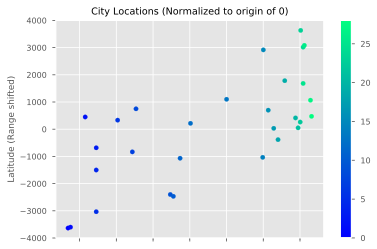

In [61]:
FILENUM                =   1
genome_length          =   DEF.read_tsp_file(FILENUM)
opt_dist, _, true_opt  =   get_best_path(FILENUM)
ea                     =   EA(PSM, RM, MM, SSM, DEF, PMM)
grapher                =   Grapher(FILENUM)
generation_limit       =   10000
print_snapshot         =   generation_limit // 25

# Plot the cities
grapher.start_up_display()

# Display a sample of Latitudes and Longitudes
grapher.cities.head(15)

### Modular Function Definitions

The modules that were imported above are designed in such a way that all of their functions take in and return the same type of data. By doing this, we can easily switch out a function to change how a phase of the algorithm behaves. Because of how the above imports are set-up, switching which function is referenced in each module changes the function used in a single line of code. Aside from ease of use, this also prevent errors from functions not getting the proper arguments, and so it also prevents needless errors when testing.

Finally, by setting the genome length, fitness evaluation, and all of the functions that the EA will use, setup is complete.
As well, any variables related to the rates and limits in the EA can be set through the helper class it contains here. For simplicity sake, it comes pre-loaded with our preferred defaults.

In [64]:
initialize           = DEF.heuristic_euler_initialization
eval_fitness         = DEF.euclidean_distance
parent_selection     = PSM.tournament
generate_offspring   = RM.pmx_crossover
apply_mutation       = MM.permutation_inversion
select_survivors     = SSM.replacement
prune_population     = PMM.static_return

ea.set_params(genome_length, eval_fitness, initialize, parent_selection, generate_offspring,
              apply_mutation, select_survivors, prune_population)

### Runtime

With all imports and object initializations out of the way, we can run the EA with a single function call: `run()`

`run()` takes in a few arguments, the only non-optional one being the `generation_limit`. The other arguments are for hw often a generation summary should be printed, the best fitness found, whether that fitness is the true optimum, and a mute boolean, for if the EA is being multi-threaded (so the outputs don't clash and clutter the terminal).

`run()` returns the best fitnees found, the idividuals with that fitness, the generation it ended on (in case of early convergence), a history of best individuals over the generations, and a tuple with the results of clocking the functions.

In [65]:
op_fit, best_indivs, gencount, run_history, time_tuple = ea.run(generation_limit, 0, print_gens=print_snapshot,
                                                                known_optimum=opt_dist, true_opt=true_opt)

Test: 0
Loaded: C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src\..\src\Setups\TSP\TSP_Inputs\TSP_Sahara_MST.txt
Test: 0
Generation: 1000
  Best fitness: 29258.33895827049
  Avg. fitness: 29797.362146780433
Test: 0
Generation: 2000
  Best fitness: 29258.33895827049
  Avg. fitness: 29456.946667133467
Test: 0
Generation: 3000
  Best fitness: 29258.33895827049
  Avg. fitness: 29559.493923834736
Test: 0
Generation: 4000
  Best fitness: 29258.33895827049
  Avg. fitness: 29491.670659820185
Test: 0
Generation: 5000
  Best fitness: 29258.33895827049
  Avg. fitness: 30043.76243015183
Test: 0
Generation: 6000
  Best fitness: 29258.33895827049
  Avg. fitness: 29399.517534656952
Test: 0
Generation: 7000
  Best fitness: 29258.33895827049
  Avg. fitness: 29643.951358742182
Test: 0
Generation: 8000
  Best fitness: 29258.33895827049
  Avg. fitness: 29565.365726595897
Test: 0
Generation: 9000
  Best fitness: 29258.33895827049
  Avg. fitness: 30461.112066041245
Test: 0
Genera

### Data Visualization

Here we plot the progression of the best fitnesses per generation.

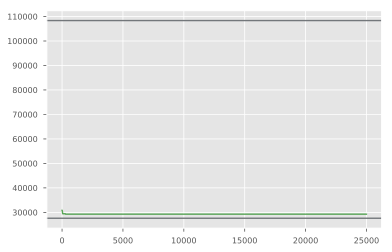

In [70]:
df = pd.DataFrame(run_history)
def plot_run(rand=False):
    df.columns = ['Fitness', 'Route']
    opt_dist, _, _ = get_best_path(FILENUM)
    df['Fitness'].plot(color=CP.SPIRIT_0)
    plt.axhline(y=opt_dist, color=CP.SPIRIT_5, label='Optimum')
    if rand: 
        rand_fit = eval_fitness(DEF.single_random_individual(genome_length))
        plt.axhline(y=rand_fit, color=CP.SPIRIT_5, label='Optimum')
    pass
plot_run()

Here we plot the optimal path that was found. One helps accent the order of the cities, while the other helps focus on the path.

In [ ]:
grapher.generation_display(generation_limit, run_history[-1][0], run_history[-1][1])
grapher.alt_generation_display(generation_limit, run_history[-1][0], run_history[-1][1])

### Previous Attempts

Over the course of doing this project, we've tried many things, and on of the things that has had the greates impact is ia good search heuristic. Below we plot an individual from each of the initiaization methods.

In [ ]:
title = 'Using {} Pop Init Method:   {:4.2f}'

### Euler Heuristic

In [ ]:
indiv = [580, 576, 606, 636, 641, 649, 663, 664, 670, 658, 662, 642, 639, 630, 614, 605, 608, 604, 628, 643, 644, 645, 654, 657, 686, 690, 696, 695, 694, 703, 700, 687, 684, 677, 671, 665, 650, 627, 626, 624, 637, 619, 573, 562, 528, 509, 505, 490, 483, 504, 501, 486, 476, 456, 436, 430, 432, 429, 416, 404, 405, 382, 379, 376, 375, 388, 408, 419, 428, 427, 444, 468, 424, 443, 455, 426, 465, 481, 515, 530, 539, 552, 564, 593, 607, 592, 548, 544, 545, 594, 666, 633, 651, 565, 523, 531, 546, 553, 527, 495, 473, 470, 440, 372, 358, 362, 346, 343, 354, 340, 333, 341, 350, 322, 309, 290, 263, 297, 315, 320, 323, 328, 327, 299, 338, 344, 345, 334, 370, 399, 377, 369, 368, 359, 385, 413, 412, 422, 431, 433, 449, 520, 524, 549, 560, 586, 597, 625, 635, 634, 638, 581, 596, 582, 701, 702, 706, 713, 716, 726, 731, 732, 709, 712, 717, 727, 718, 719, 720, 714, 708, 707, 704, 730, 729, 728, 725, 724, 721, 710, 715, 705, 699, 697, 689, 698, 685, 680, 673, 659, 681, 653, 668, 656, 676, 672, 661, 648, 646, 647, 655, 669, 679, 683, 688, 675, 652, 674, 682, 693, 678, 692, 723, 722, 733, 711, 691, 667, 660, 640, 602, 568, 595, 567, 452, 458, 423, 394, 400, 386, 418, 425, 442, 411, 401, 459, 454, 471, 448, 472, 480, 500, 632, 622, 613, 590, 575, 557, 535, 522, 525, 516, 511, 503, 489, 475, 499, 493, 484, 478, 461, 453, 464, 469, 479, 492, 507, 536, 534, 498, 497, 513, 491, 488, 487, 502, 510, 547, 563, 585, 587, 603, 609, 615, 623, 618, 598, 591, 572, 551, 540, 533, 532, 537, 554, 569, 529, 506, 485, 474, 477, 496, 434, 457, 441, 435, 421, 415, 409, 407, 417, 391, 389, 410, 446, 445, 447, 450, 438, 437, 367, 363, 339, 331, 335, 329, 304, 300, 251, 235, 233, 204, 219, 226, 230, 223, 238, 242, 250, 234, 232, 229, 206, 198, 185, 199, 175, 177, 166, 167, 162, 160, 156, 159, 155, 141, 136, 130, 118, 111, 106, 110, 113, 116, 129, 138, 154, 174, 165, 152, 153, 148, 134, 96, 81, 63, 77, 95, 98, 102, 86, 31, 29, 32, 34, 36, 47, 51, 56, 58, 60, 87, 61, 69, 88, 89, 107, 103, 112, 139, 133, 131, 124, 142, 146, 150, 104, 73, 72, 71, 74, 75, 67, 57, 66, 62, 53, 52, 49, 43, 40, 55, 65, 99, 120, 123, 122, 119, 125, 94, 82, 68, 59, 54, 37, 30, 28, 19, 8, 12, 13, 11, 14, 9, 7, 3, 4, 6, 1, 0, 2, 5, 10, 21, 17, 15, 26, 46, 45, 44, 35, 24, 20, 18, 16, 25, 23, 22, 27, 33, 39, 38, 42, 50, 91, 97, 41, 48, 64, 70, 101, 100, 93, 105, 121, 137, 145, 173, 182, 193, 218, 222, 224, 231, 237, 254, 258, 287, 286, 289, 298, 310, 332, 355, 285, 282, 274, 257, 307, 319, 306, 253, 249, 227, 221, 213, 203, 209, 220, 248, 278, 277, 284, 292, 296, 301, 317, 308, 318, 326, 348, 361, 365, 366, 353, 349, 403, 393, 390, 398, 381, 397, 406, 396, 395, 384, 392, 387, 402, 414, 439, 451, 463, 460, 467, 466, 494, 360, 357, 314, 302, 281, 215, 205, 192, 196, 184, 187, 171, 163, 157, 143, 135, 115, 127, 128, 140, 144, 147, 176, 151, 197, 200, 172, 201, 210, 216, 217, 259, 272, 303, 275, 240, 225, 202, 188, 149, 158, 178, 243, 273, 283, 276, 266, 267, 271, 279, 260, 264, 265, 244, 252, 236, 268, 261, 269, 262, 280, 288, 255, 245, 246, 256, 241, 247, 270, 239, 228, 208, 212, 181, 180, 191, 214, 183, 195, 186, 194, 190, 179, 164, 161, 168, 189, 211, 170, 169, 132, 117, 109, 108, 92, 83, 84, 78, 79, 80, 90, 85, 76, 114, 126, 313, 325, 324, 321, 336, 337, 347, 352, 373, 374, 383, 371, 380, 364, 351, 330, 342, 311, 305, 293, 207, 291, 294, 295, 316, 312, 356, 378, 420, 462, 482, 512, 518, 519, 514, 521, 508, 517, 526, 543, 538, 542, 550, 558, 584, 612, 621, 617, 631, 629, 601, 571, 589, 620, 566, 579, 588, 611, 616, 583, 578, 574, 610, 600, 599, 577, 559, 555, 541, 556, 570, 561]
DEF.heuristic_euler_initialization(1, genome_length)
hero = DEF.single_euler_individual(genome_length)
grapher.generation_display("Euler Hueristic", eval_fitness(hero), hero)

### Cluster Heuristic

In [ ]:
DEF.heuristic_cluster_initialization(1, genome_length)
heuro = DEF.single_cluster_individual(genome_length)
grapher.generation_display("Cluster Hueristic", eval_fitness(heuro), heuro)

### Ordered List

In [ ]:
ordo = [x for x in range(genome_length)]
grapher.generation_display("Ordered", eval_fitness(ordo), ordo)

### Random

In [ ]:
rando = DEF.single_random_individual(genome_length)
grapher.generation_display("Random", eval_fitness(rando), rando)

In [ ]:
plot_run(True)

# Statistics and Graphs

In [49]:
from src.StatsHolder import StatsHolder

def resolve_unpickle_tuples(method_name, country, implementation):
    # (File_name, country, method)
    if method_name == 'Population':
        return [(base_filename.format(x, _ , _), country, implementation) for x in range(3)]
    if method_name == 'Mutation':
        return [(base_filename.format(_, x , _), country, implementation) for x in range(4)]
    if method_name == 'Management':
        return [('21021{} G10000.txt'.format(x), country, implementation) for x in range(5)]
    
def pickle_to_df(identity_tuple, truncate):
    method_name, country, implementation = identity_tuple
    
    to_unpickle = resolve_unpickle_tuples(method_name, country, implementation)
    stat_objs = [StatsHolder.stat_obj_from_pickle(x) for x in to_unpickle]
    summaries = [s.average_generation_fitness() for s in stat_objs]
    optimums = [s.best_generation_fitness() for s in stat_objs]
    x_axis = {'x': [x for x in range(len(summaries[0]))][truncate:-1]}
    if method_name == 'Population':
        summaries = {stat_objs[y].POPULATION_METHOD : summaries[y][truncate:-1] for y in range(len(summaries))}
        optimums = {stat_objs[y].POPULATION_METHOD : optimums[y][truncate:-1] for y in range(len(optimums))}
    if method_name == 'Mutation':
        summaries = {stat_objs[y].MUTATION_METHOD : summaries[y][truncate:-1] for y in range(len(summaries))}
        optimums = {stat_objs[y].MUTATION_METHOD : optimums[y][truncate:-1] for y in range(len(optimums))}
    if method_name == 'Management':
        summaries = {stat_objs[y].MANAGEMENT_METHOD : summaries[y][truncate:-1] for y in range(len(summaries))}
        optimums = {stat_objs[y].MANAGEMENT_METHOD : optimums[y][truncate:-1] for y in range(len(optimums))}
    
    
    return pd.DataFrame({**x_axis, **summaries}), pd.DataFrame({**x_axis, **optimums})
    

id_tuple = ('Management', 1, 0)
avgs, opts = pickle_to_df(id_tuple, 0)

Loaded: C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src\..\Results\Sahara\Lists\210210 G10000.txt
Loaded: C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src\..\Results\Sahara\Lists\210211 G10000.txt
Loaded: C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src\..\Results\Sahara\Lists\210212 G10000.txt
Loaded: C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src\..\Results\Sahara\Lists\210213 G10000.txt
Loaded: C:\Users\Zachary\Documents\GitHub\COMP 3201 - TSP Evolutionary Algorithm\src\..\Results\Sahara\Lists\210214 G10000.txt


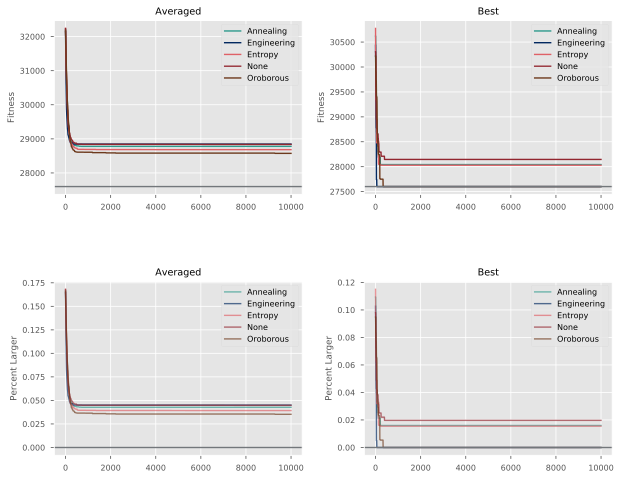

In [52]:
def long_plot(avgs, opts, dataset):
    opt_dist, _, _ = get_best_path(dataset)
    colours = [CP.SPIRIT_0, CP.SPIRIT_1, CP.SPIRIT_2, CP.SPIRIT_9, CP.SPIRIT_7, CP.SPIRIT_6]
    fig, axes = plt.subplots(nrows=2, figsize=(11.5, 8))
    plt.subplots_adjust(wspace=0.25, hspace=0.4)
    def plot_df(df, axis):
        num = 0
        for column in df.drop('x', axis=1):
            num += 1
            # plt.plot(df['x'], df[column], ax=axes[axis], marker='', color=colours[num], linewidth=1, alpha=0.9, label=column)
            df[column].plot(ax=axes[axis], color=colours[num], legend=True)
            #((df[column] / opt_dist) - 1).plot(ax=axes[axis], color=colours[num], alpha=0.0, secondary_y=True, legend=False)
            #df.plot(ax=axes[axis], color=CP.KIKI_6, legend=True)
            #df.plot(ax=axes[axis], color=CP.KIKI_7, alpha=0.33, secondary_y=True, legend=True)
            #df.plot(ax=axes[axis], color=CP.KIKI_6, alpha=0.33, secondary_y=True, legend=True)

    plot_df(avgs, 0)
    axes[0].axhline(y=opt_dist, color=CP.SPIRIT_5, label='Optimum')
    axes[0].set_title("Average fitnesses over multiple runs", fontsize=12, fontweight=0, color=CP.SPIRIT_3)
    axes[0].set_xlabel("Generations")
    axes[0].set_ylabel("Fitness")
    axes[0].right_ax.set_ylabel('Relative Fitness')

    plot_df(opts, 1)
    axes[1].axhline(y=opt_dist, color=CP.SPIRIT_5, label='Optimum')
    axes[1].set_title("Best fitnesses over multiple runs", fontsize=12, fontweight=0, color=CP.SPIRIT_3)
    axes[1].set_xlabel("Generations")
    axes[1].set_ylabel("Fitness")
    axes[1].right_ax.set_ylabel('Relative Fitness')


def dual_plot(avgs, opts, dataset):
    opt_dist, _, _ = get_best_path(dataset)
    colours = [CP.SPIRIT_0, CP.SPIRIT_1, CP.SPIRIT_2, CP.SPIRIT_9, CP.SPIRIT_7, CP.SPIRIT_6]
    plt.style.use(plt.style.available[13])  ##4, 13, 21 
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
    plt.subplots_adjust(wspace=0.25, hspace=0.5)

    def plot_df(df, ax1, ax2, per):
        num = 0
        if ax2 == 0: axes[ax1, ax2].set_title('Averaged')
        if ax2 == 1: axes[ax1, ax2].set_title('Best')
        if per: axes[ax1, ax2].set_ylabel('Percent Larger') 
        else: axes[ax1, ax2].set_ylabel('Fitness')
        for column in df.drop('x', axis=1):
            num += 1
            if per: ((df[column] / opt_dist) - 1).plot(ax=axes[ax1, ax2], color=colours[num], alpha=0.66, legend=True)
            else: df[column].plot(ax=axes[ax1, ax2], color=colours[num], legend=True)
        if per: axes[ax1, ax2].axhline(y=0, color=CP.SPIRIT_5, label='Optimum')
        else: axes[ax1, ax2].axhline(y=opt_dist, color=CP.SPIRIT_5, label='Optimum')

    with pd.plotting.plot_params.use('x_compat', True):
        plot_df(avgs, 0, 0, False)
    with pd.plotting.plot_params.use('x_compat', True):
        plot_df(opts, 0, 1, False)
    with pd.plotting.plot_params.use('x_compat', True):
        plot_df(avgs, 1, 0, True)
    with pd.plotting.plot_params.use('x_compat', True):
        plot_df(opts, 1, 1, True)

dual_plot(avgs, opts, id_tuple[1])